# Lesson 13.2 模型拟合度概念介绍与欠拟合模型的结构调整策略

## 一、模型拟合度概念介绍与实验

### 1.测试集的“不可知”悖论

&emsp;&emsp;通过此前课程内容介绍，我们已经知道了机器学习模型主要通过模型在测试集上的运行效果来判断模型好坏，测试集相当于是“高考”，而此前的模型训练都相当于是在练习，但怎么样的练习才能有效的提高高考成绩，这里就存在一个“悖论”，那就是练习是为了高考，而在高考前我们永远不知道练习是否有效，那高考对于练习的核心指导意义何在？在机器学习领域，严格意义上的测试集是不能参与建模的，此处不能参与建模，不仅是指在训练模型时不能带入测试集进行训练，更是指当模型训练完成之后、观察模型在测试集上的运行结果后，也不能据此再进行模型修改（比如增加神经网络层数），后面我们会提到，把数据带入模型训练是影响模型参数，而根据模型运行结果再进行模型结构调整，实际上是修改了模型超参数，不管是修改参数还是超参数，都是影响了模型建模过程，都相当于是带入进行了建模。是的，如果通过观察测试集结果再调整模型结构，也相当于是带入测试集数据进行训练，而严格意义上的测试集，是不能带入模型训练的。（这是一个有点绕的“悖论”....）

&emsp;&emsp;但是，还记得我们此前说的，机器学习建模的核心目标就是提升模型的泛化能力么？而泛化能力指的是在模型未知数据集（没带入进行训练的数据集）上的表现，虽然测试集只能测一次，但我们还是希望有机会能把模型带入未知数据集进行测试，此时我们就需要一类新的数据集——验证集。验证集在模型训练阶段不会带入模型进行训练，但当模型训练结束之后，我们会把模型带入验证集进行计算，通过观测验证集上模型运行结果，判断模型是否要进行调整，验证集也会模型训练，只不过验证集训练的不是模型参数，而是模型超参数，关于模型参数和超参数的概念后面还会再详细讨论，当然，我们也可以把验证集看成是应对高考的“模拟考试”，通过“模拟考试”的考试结果来调整复习策略，从而更好的应对“高考”。总的来说，测试集是严格不能带入训练的数据集，在实际建模过程中我们可以先把测试集切分出来，然后“假装这个数据集不存在”，在剩余的数据集中划分训练集和验证集，把训练集带入模型进行运算，再把验证集放在训练好的模型中进行运行，观测运行结果，再进行模型调整。

&emsp;&emsp;总的来说，在模型训练和观测模型运行结果的过程总共涉及三类数据集，分别是训练集、验证集和测试集。不过由于测试集定位特殊，在一些不需要太严谨的场景下，有时也会混用验证集和测试集的概念，我们常常听到“测试集效果不好、重新调整模型”等等，都是混用了二者概念，由于以下是模拟练习过程，暂时不做测试集和验证集的区分。在不区分验证集和测试集的情况下，当数据集切分完成后，对于一个模型来说，我们能够获得两套模型运行结果，一个是训练集上模型效果，一个是测试集上模型效果，而这组结果，就将是整个模型优化的基础数据。

> 在某些场景下，测试集确实是严格不可知的，比如在线提交结果的数据竞赛。

In [2]:
# 随机模块
import random

# 绘图模块
import matplotlib as mpl
import matplotlib.pyplot as plt

# numpy
import numpy as np

# pytorch
import torch
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import Dataset,TensorDataset,DataLoader
from torch.utils.tensorboard import SummaryWriter

# 自定义模块
from torchLearning import *

# 导入以下包从而使得可以在jupyter中的一个cell输出多个结果
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### 2.模型拟合度概念与实验

&emsp;&emsp;在所有的模型优化问题中，最基础的也是最核心的问题，就是关于模型拟合程度的探讨与优化。根据此前的讨论，模型如果能很好的捕捉总体规律，就能够有较好的未知数据的预测效果。但限制模型捕捉总体规律的原因主要有两点：
- 其一，样本数据能否很好的反应总体规律      
&emsp;&emsp;如果样本数据本身无法很好的反应总体规律，那建模的过程就算捕捉到了规律可能也无法适用于未知数据。举个极端的例子，在进行反欺诈检测时，如果要基于并未出现过欺诈案例的历史数据来进行建模，那模型就将面临无规律可捕捉的窘境，当然，确切的说，是无可用规律可捕捉；或者，当扰动项过大时，噪声也将一定程度上掩盖真实规律。
- 其二，样本数据能反应总体规律，但模型没有捕捉到     
&emsp;&emsp;如果说要解决第一种情况需要在数据获取端多下功夫，那么如果数据能反应总体规律而模型效果不佳，则核心原因就在模型本身了。此前介绍过，机器学习模型评估主要依据模型在测试集上的表现，如果测试集效果不好，则我们认为模型还有待提升，但导致模型在测试集上效果不好的原因其实也主要有两点，其一是模型没捕捉到训练集上数据的规律，其二则是模型过分捕捉训练集上的数据规律，导致模型捕获了大量训练集独有的、无法适用于总体的规律（局部规律），而测试集也是从总体中来，这些规律也不适用于测试集。前一种情况我们称模型为欠拟合，后一种情况我们称模型为过拟合，我们可以通过以下例子进行进一步了解：

In [3]:
# 设计随机数种子
np.random.seed(123)

# 创建数据
n_dots = 20
x = np.linspace(0, 1, n_dots)                        # 从0到1，等宽排布的20个数
y = np.sqrt(x) + 0.2*np.random.rand(n_dots) - 0.1    

In [4]:
np.random.rand(10)

array([0.63440096, 0.84943179, 0.72445532, 0.61102351, 0.72244338,
       0.32295891, 0.36178866, 0.22826323, 0.29371405, 0.63097612])

其中，x是一个0到1之间等距分布20个点组成的ndarray，$y=\sqrt{x}+r$，其中r是人为制造的随机噪声，在[-0.1,0.1]之间服从均匀分布。然后我们借助numpy的polyfit函数来进行多项式拟合，polyfit函数会根据设置的多项式阶数，在给定数据的基础上利用最小二乘法进行拟合，并返回拟合后各阶系数。该函数更多相关参数详见[numpy.polynomial.polynomial.polyfit](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.polynomial.polynomial.polyfit.html)官网API讲解。同时，当系数计算完成后，我们还常用ploy1d函数逆向构造多项式方程，进而利用方程求解y，该函数用法参见[numpy.poly1d](https://docs.scipy.org/doc/numpy/reference/generated/numpy.poly1d.html)官网说明。

例如人为制造一个二阶多项式方程然后进行二阶拟合实验

In [5]:
y0 = x ** 2
np.polyfit(x, y0, 2)

array([ 1.00000000e+00, -2.00019564e-18, -3.29090297e-17])

能够得出多项式各阶系数，而根据该系数可用ploy1d逆向构造多项式方程

In [6]:
p = np.poly1d(np.polyfit(x, y0, 2))
print(p)

   2
1 x - 2e-18 x - 3.291e-17


能够看到多项式结构基本和原多项式保持一致，此时生成的p对象相当于是一个多项式方程，可通计算输入参数的多项式输出结果

In [7]:
p(-1)

1.0

接下来，进行多项式拟合。分别利用1阶x多项式、3阶x多项式和10阶x多项式来拟合y。并利用图形观察多项式的拟合度，首先我们可定义一个辅助画图函数，方便后续我们将图形画于一张画布中，进而方便观察

In [8]:
def plot_polynomial_fit(x, y, deg):
    p = np.poly1d(np.polyfit(x, y, deg))
    t = np.linspace(0, 1, 200)
    plt.plot(x, y, 'ro', t, p(t), '-', t, np.sqrt(t), 'r--')

其中，t为[0,1]中等距分布的100个点，而p是deg参数决定的多项式回归拟合方程，p(t)即为拟合方程x输入t值时多项式输出结果，此处plot_polynomial_fit函数用于生成同时包含（x，y）原始值组成的红色点图、（t，p(t)）组成的默认颜色的曲线图、（t，np.sqrt(t)）构成的红色虚线曲线图。测试3阶多项式拟合结果

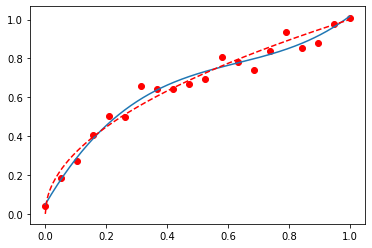

In [9]:
plot_polynomial_fit(x, y, 3)

这里需要注意(x,y)组成的红色点图相当于带有噪声的二维空间数据分布，(t, p(t))构成的蓝色曲线相当于3阶多项式拟合原数据集（(x, y)数据集）后的结果，而原始数据集包含的客观规律实际上是$y=\sqrt{x}$，因此最后红色的虚线（t, np.sqrt(t)）实际上是代表红色点集背后的客观规律，即我们希望拟合多项式（蓝色曲线）能够尽可能的拟合代表客观规律的红色虚线，而不是被噪声数据所吸引偏离红色虚线位置，同时也不希望完全没有捕捉到红色曲线的规律。接下来，我们尝试将1阶拟合、3阶拟合和10阶拟合绘制在一张图中。

<Figure size 3600x800 with 0 Axes>

Text(0.5, 1.0, 'Under Fitting')

Text(0.5, 1.0, 'Fitting')

Text(0.5, 1.0, 'Over Fitting')

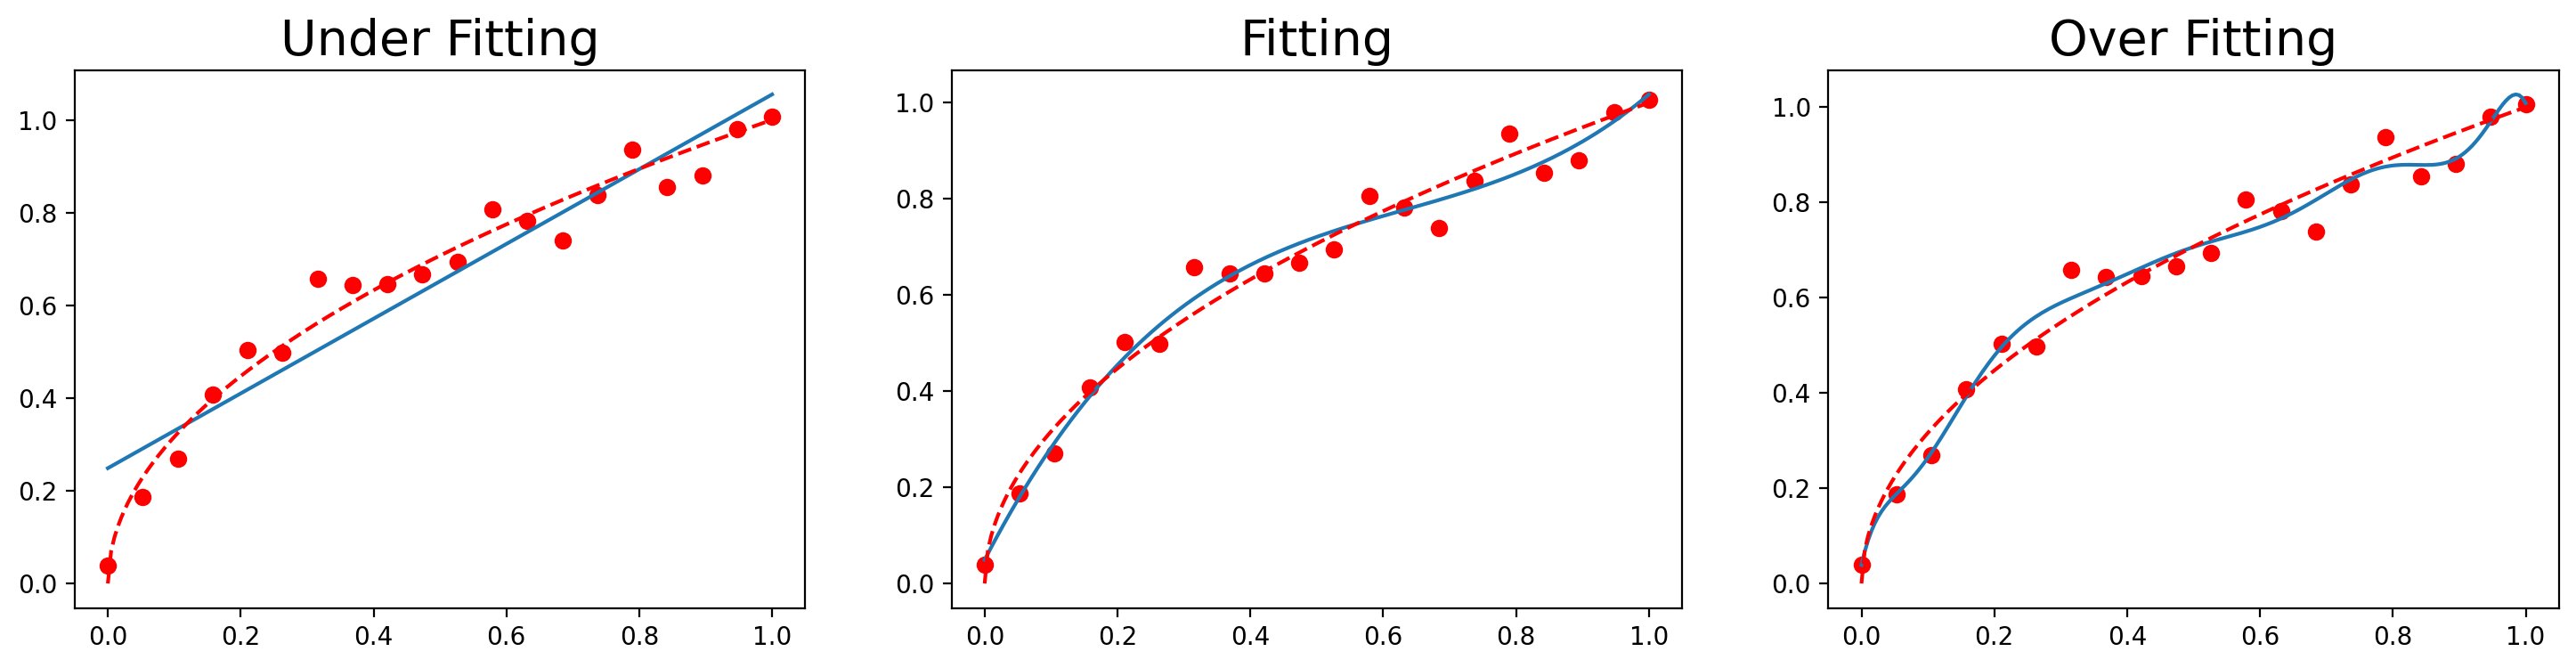

In [10]:
plt.figure(figsize=(18, 4), dpi=200)
titles = ['Under Fitting', 'Fitting', 'Over Fitting']
for index, deg in enumerate([1, 3, 10]):
    plt.subplot(1, 3, index + 1)
    plot_polynomial_fit(x, y, deg)
    plt.title(titles[index], fontsize=20)

&emsp;&emsp;根据最终的输出结果我们能够清楚的看到，1阶多项式拟合的时候蓝色拟合曲线即无法捕捉数据集的分布规律，离数据集背后客观规律也很远，而三阶多项式在这两方面表现良好，十阶多项式则在数据集分布规律捕捉上表现良好，单同样偏离红色曲线较远。此时一阶多项式实际上就是欠拟合，而十阶多项式则过分捕捉噪声数据的分布规律，而噪声之所以被称作噪声，是因为其分布本身毫无规律可言，或者其分布规律毫无价值（如此处噪声分布为均匀分布），因此就算十阶多项式在当前训练数据集上拟合度很高，但其捕捉到的无用规律无法推广到新的数据集上，因此该模型在测试数据集上执行过程将会有很大误差。即模型训练误差很小，但泛化误差很大。

> 不难发现，过拟合产生的根本原因，还是样本之间有“误差”，或者不同批次的数据规律不完全一致。

因此，我们有基本结论如下：      
- 模型欠拟合：训练集上误差较大
- 模型过拟合：训练集上误差较小，但测试集上误差较大

而模型是否出现欠拟合或者过拟合，其实和模型复杂度有很大关系。我们通过上述模型不难看出，模型越复杂，越有能力捕捉训练集上的规律，因此如果模型欠拟合，我们可以通过提高模型复杂度来进一步捕捉规律，但同时也会面临模型过于复杂而导致过拟合的风险。

<img src="https://i.loli.net/2021/02/06/kSiX5adUTybOePf.jpg" alt="44" style="zoom:50%;" />

对于深度学习来说，模型复杂度和模型结构直接相关，隐藏层越多、每一层神经元越多、模型就越复杂，当然模型复杂度还和激活函数有关。模型拟合度优化是模型优化的核心，深度学习模型的一系列优化方法也基本是根据拟合度优化这一核心目标衍生出来的，接下来，我们就来看下如何通过调整模型结构来进行拟合度优化。

## 二、模型欠拟合实例

&emsp;&emsp;首先我们来讨论模型欠拟合时，通过提升模型复杂度提升模型效果的基本方法。当然，从神经网络整体模型结构来看，提升复杂度只有两种办法，其一是修改激活函数，在神经元内部对加权求和汇总之后的值进行更加复杂的处理，另一种方法则是添加隐藏层，包括隐藏层层数和每一层隐藏层的神经元个数。接下来我们通过一些列实验来查看相关效果。

&emsp;&emsp;还是多元线性回归的例子，如果是高次项方程，通过简单的线性网络拟合就会出现欠拟合的情况。

- 构建数据集

创建一个数据满足$y = 2x_1^2 - x_2^2$方程的分布数组

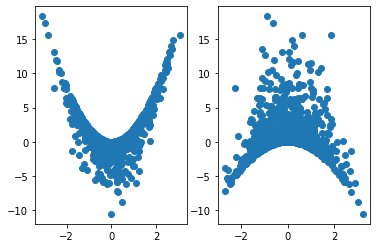

In [11]:
# 设置随机数种子
torch.manual_seed(420)  

# 创建最高项为2的多项式回归数据集
features, labels = tensorGenReg(w=[2, -1], bias=False, deg=2)

# 绘制图像查看数据分布
plt.subplot(121)
plt.scatter(features[:, 0], labels)
plt.subplot(122)
plt.scatter(features[:, 1], labels)

In [12]:
features

tensor([[-0.0070,  0.5044],
        [ 0.6704, -0.3829],
        [ 0.0302,  0.3826],
        ...,
        [-0.9164, -0.6087],
        [ 0.7815,  1.2865],
        [ 1.4819,  1.1390]])

In [13]:
# 进行数据集切分与加载
train_loader, test_loader = split_loader(features, labels)

- 训练模型

首先定义简单线性回归模型

In [14]:
class LR_class(nn.Module):                                         # 没有激活函数
    def __init__(self, in_features=2, out_features=1):       # 定义模型的点线结构
        super(LR_class, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):                                    # 定义模型的正向传播规则
        out = self.linear(x)             
        return out

然后执行模型训练

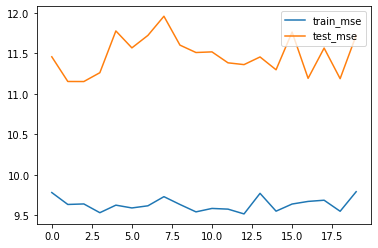

In [15]:
# 设置随机数种子
torch.manual_seed(420)  

# 实例化模型
LR = LR_class()

train_l = []           # 列表容器，存储训练误差
test_l = []            # 列表容器，存储测试误差

num_epochs = 20

# 执行循环
for epochs in range(num_epochs):
    fit(net = LR,
        criterion = nn.MSELoss(),
        optimizer = optim.SGD(LR.parameters(), lr = 0.03),
        batchdata = train_loader,
        epochs = epochs)
    train_l.append(mse_cal(train_loader, LR).detach().numpy())
    test_l.append(mse_cal(test_loader, LR).detach().numpy())
    
# 绘制图像，查看MSE变化情况
plt.plot(list(range(num_epochs)), train_l, label='train_mse')
plt.plot(list(range(num_epochs)), test_l, label='test_mse')
plt.legend(loc = 1)

对比此前线性回归的MSE，上述模型效果较差，且训练误差和测试误差均较大（此前是0.0001），模型存在欠拟合情况，接下来考虑增加模型复杂程度。我们可以根据上述过程定义一个记录、对比模型训练过程训练集、测试集误差变化情况的函数，并写入模块文件。

In [16]:
def model_train_test(model, 
                     train_data,
                     test_data,
                     num_epochs = 20, 
                     criterion = nn.MSELoss(), 
                     optimizer = optim.SGD, 
                     lr = 0.03, 
                     cla = False, 
                     eva = mse_cal):
    """模型误差测试函数：
    
    :param model_l：模型
    :param train_data：训练数据
    :param test_data: 测试数据   
    :param num_epochs：迭代轮数
    :param criterion: 损失函数
    :param lr: 学习率
    :param cla: 是否是分类模型
    :return：MSE列表
    """
    
    # 模型评估指标列表
    train_l = []
    test_l = []
    # 模型训练过程
    for epochs in range(num_epochs):
        fit(net = model, 
            criterion = criterion, 
            optimizer = optimizer(model.parameters(), lr = lr), 
            batchdata = train_data, 
            epochs = epochs, 
            cla = cla)
        train_l.append(eva(train_data, model).detach())
        test_l.append(eva(test_data, model).detach())
    return train_l, test_l

测试模型效果

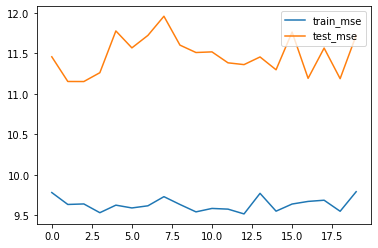

In [17]:
# 设置随机数种子
torch.manual_seed(420)  

# 实例化模型
LR = LR_class()

# 模型训练
train_l, test_l = model_train_test(LR, 
                                   train_loader,
                                   test_loader,
                                   num_epochs = 20, 
                                   criterion = nn.MSELoss(), 
                                   optimizer = optim.SGD, 
                                   lr = 0.03, 
                                   cla = False, 
                                   eva = mse_cal)

# 绘制图像，查看MSE变化情况
plt.plot(list(range(num_epochs)), train_l, label='train_mse')
plt.plot(list(range(num_epochs)), test_l, label='test_mse')
plt.legend(loc = 1)

在神经网络基本结构下，如何提升模型复杂度从而使得可以对多元线性回归数据进行建模呢？首先，在激活函数仅为线性变换$y=x$情况下，增加层数并不会对结果有显著提升，我们可以通过如下实验验证：

In [18]:
class LR_class1(nn.Module):                                         
    def __init__(self, in_features=2, n_hidden=4, out_features=1):       # 此处隐藏层设置四个激活函数
        super(LR_class1, self).__init__()
        self.linear1 = nn.Linear(in_features, n_hidden)
        self.linear2 = nn.Linear(n_hidden, out_features)
        
    def forward(self, x):                                    
        z1 = self.linear1(x)
        out = self.linear2(z1)             
        return out

这里我们构建了一个两层都是线性层的神经网络，并且没有加入激活函数。对于神经网络来说，复杂模型的构建就是Module的叠加，核心需要注意整个传播过程计算流程是否完整。

In [19]:
# 设置随机数种子
torch.manual_seed(420)  

# 实例化模型
LR1 = LR_class1()

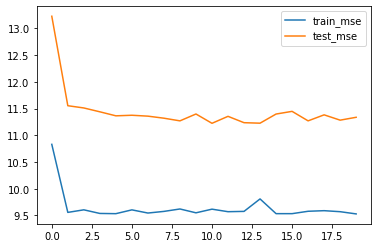

In [20]:
# 设置随机数种子
torch.manual_seed(420)  

# 实例化模型
LR1 = LR_class1()

# 模型训练
train_l, test_l = model_train_test(LR1, 
                                   train_loader,
                                   test_loader,
                                   num_epochs = 20, 
                                   criterion = nn.MSELoss(), 
                                   optimizer = optim.SGD, 
                                   lr = 0.03, 
                                   cla = False, 
                                   eva = mse_cal)

# 绘制图像，查看MSE变化情况
plt.plot(list(range(num_epochs)), train_l, label='train_mse')
plt.plot(list(range(num_epochs)), test_l, label='test_mse')
plt.legend(loc = 1)

我们发现，结果没有显著提升，但模型稳定性却有所提升。对于叠加线性层的神经网络模型来说，由于模型只是对数据仿射变换，因此并不能满足拟合高次项的目的。也就是说，在增加模型复杂度的过程中，首先需要激活函数的配合，然后再是增加模型的层数和每层的神经元个数。

> 此处我们发现，模型越复杂，输出结果越平稳，但这只是一个局部规律，其实在大多数时候，模型越复杂，输出结果越不一定平稳。

## 三、激活函数性能比较

&emsp;&emsp;对于激活函数来说，不同激活函数效果差异非常明显，再初学阶段，我们以学会并熟练使用常用激活函数为主，在进阶阶段，我们将尝试自定义激活函数。那么接下来，就让我们来测试不同激活函数在上述数据集中的表现。

### 1.常用激活函数对比

&emsp;&emsp;首先我们将此前介绍的几个常用激活函数应用在当前数据集中检测效果。此处都是在上述线性模型基础上再输出层添加激活函数。也就构建包含一个隐藏层的模型，并且在隐藏层中设置不同的激活函数进行尝试。      
&emsp;&emsp;正如Lesson 11中所谈到的，输出层的激活函数和隐藏层的激活函数应该分开对待，隐藏层的激活函数是为了对数据进行非线性变换，而输出层的激活函数一般都是为了满足某种特定的输出结果所设计的，如softmax（是的，softmax也可以看成是激活函数）、Sigmoid等，而在其他情况下，而在当前实验中，由于是进行回归类问题实验，在输出层加入激活函数反而会影响输出结果。

- 创建模型类

模型结构如下

<center><img src="https://i.loli.net/2021/02/26/fOKePkACV54Fya9.jpg" alt="66" style="zoom:40%;" />

相关类的定义如下

In [21]:
# Sigmoid激活函数
class Sigmoid_class1(nn.Module):                                   
    def __init__(self, in_features=2, n_hidden=4, out_features=1, bias = True):       
        super(Sigmoid_class1, self).__init__()
        self.linear1 = nn.Linear(in_features, n_hidden, bias=bias)
        self.linear2 = nn.Linear(n_hidden, out_features, bias=bias)
        
    def forward(self, x):                                   
        z1 = self.linear1(x)
        p1 = torch.sigmoid(z1)                   
        out = self.linear2(p1)
        return out

    
# tanh激活函数
class tanh_class1(nn.Module):                                   
    def __init__(self, in_features=2, n_hidden=4, out_features=1, bias = True):       
        super(tanh_class1, self).__init__()
        self.linear1 = nn.Linear(in_features, n_hidden, bias=bias)
        self.linear2 = nn.Linear(n_hidden, out_features, bias=bias)
        
    def forward(self, x):                                   
        z1 = self.linear1(x)
        p1 = torch.tanh(z1)                   
        out = self.linear2(p1)
        return out

    
# ReLU激活函数
class ReLU_class1(nn.Module):                                   
    def __init__(self, in_features=2, n_hidden=4, out_features=1, bias = True):       
        super(ReLU_class1, self).__init__()
        self.linear1 = nn.Linear(in_features, n_hidden, bias=bias)
        self.linear2 = nn.Linear(n_hidden, out_features, bias=bias)
        
    def forward(self, x):                                   
        z1 = self.linear1(x)
        p1 = torch.relu(z1)                  
        out = self.linear2(p1)
        return out

> 注，除了torch.方法以外，上述三个激活函数还能使用F.方法，不过根据PyTorch的相关说明，推荐使用torch.方法执行。

In [22]:
t = torch.randn(5)
t

tensor([-1.3191, -1.2474,  1.8058,  1.4594, -0.1661])

In [23]:
F.relu(t)

tensor([0.0000, 0.0000, 1.8058, 1.4594, 0.0000])

In [24]:
torch.relu(t)

tensor([0.0000, 0.0000, 1.8058, 1.4594, 0.0000])

In [25]:
F.sigmoid(t)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([0.2110, 0.2232, 0.8589, 0.8114, 0.4586])

In [26]:
torch.sigmoid(t)

tensor([0.2110, 0.2232, 0.8589, 0.8114, 0.4586])

- 实例化模型

In [27]:
torch.manual_seed(420)  

LR1 = LR_class1()
sigmoid_model1 = Sigmoid_class1()
tanh_model1 = tanh_class1()
relu_model1 = ReLU_class1()

model_l = [LR1, sigmoid_model1, tanh_model1, relu_model1]           # 将实例化后模型放在一个列表容器中
name_l = ['LR1', 'sigmoid_model1', 'tanh_model1', 'relu_model1']

- 定义核心参数

In [28]:
num_epochs = 30
lr = 0.03

- 定义训练集、测试集MSE存储张量

&emsp;&emsp;为了能够同属存储多个模型的训练误差和测试误差，我们这里通过张量的方式（有结构的对象）来进行存储。其中，张量的行数就是模型列表的元素个数（模型个数），列数就是总共迭代轮数。实际运行过程中，张量的每一行用于存储每个模型迭代不同轮数时MSE的计算结果，不同行则代表不同模型的计算结果。

In [29]:
mse_train = torch.zeros(len(model_l), num_epochs)
mse_test = torch.zeros(len(model_l), num_epochs)

In [30]:
mse_train.shape

torch.Size([4, 30])

- 训练模型

In [31]:
for epochs in range(num_epochs):
    for i, model in enumerate(model_l):
        fit(net = model, 
            criterion = nn.MSELoss(), 
            optimizer = optim.SGD(model.parameters(), lr = lr), 
            batchdata = train_loader, 
            epochs = epochs)
        mse_train[i][epochs] = mse_cal(train_loader, model).detach()
        mse_test[i][epochs] = mse_cal(test_loader, model).detach()

In [32]:
mse_train
mse_test

tensor([[10.8300,  9.6960,  9.5622,  9.5223,  9.5458,  9.5954,  9.5359,  9.6136,
          9.5801,  9.5964,  9.6088,  9.5391,  9.5435,  9.6457,  9.5339,  9.6280,
          9.5463,  9.5790,  9.5291,  9.6231,  9.6323,  9.5592,  9.7235,  9.6189,
          9.6135,  9.5363,  9.6436,  9.5781,  9.5489,  9.5466],
        [10.7485,  9.6246,  9.2736,  7.1681,  4.2412,  3.0897,  2.8030,  2.6019,
          2.5310,  2.4331,  2.4021,  2.4125,  2.4407,  2.3779,  2.3087,  2.5533,
          2.3416,  2.3221,  2.6079,  2.3055,  2.3146,  2.3081,  2.3664,  3.1914,
          2.2998,  2.4680,  2.2942,  2.6507,  2.3046,  2.4291],
        [10.7273,  9.0404,  6.0416,  5.0775,  4.6106,  4.4453,  4.3490,  4.7661,
          4.3492,  4.2997,  4.2669,  4.3732,  4.2767,  4.2490,  4.4358,  4.3139,
          4.2618,  4.4504,  4.3120,  4.3259,  4.2744,  4.4678,  4.2618,  4.3907,
          4.2713,  4.2294,  4.2711,  4.2295,  4.2537,  4.2408],
        [10.2269,  1.5506,  0.6582,  0.6659,  0.3920,  0.3590,  0.3089,  0.3818

tensor([[13.2264, 11.4769, 11.3752, 11.3732, 11.2853, 11.2702, 11.2457, 11.5075,
         11.2162, 11.7994, 11.5239, 11.4593, 11.3358, 11.6676, 11.3245, 11.5025,
         11.3631, 11.2606, 11.2952, 11.7086, 11.7071, 11.2788, 11.7602, 11.4373,
         11.1840, 11.3217, 11.4141, 11.3705, 11.3440, 11.3679],
        [13.1832, 11.2691, 10.6894,  8.7440,  5.0175,  3.4692,  2.7936,  2.4461,
          2.3718,  2.0881,  2.0349,  2.0134,  2.0608,  1.9349,  1.8626,  2.1943,
          1.7982,  1.8370,  2.1317,  1.8005,  1.8485,  1.8082,  1.9161,  2.7955,
          1.8118,  2.0475,  1.7516,  2.2262,  1.7782,  2.0306],
        [12.6266, 10.7718,  7.4650,  6.6652,  5.8065,  5.9088,  5.7766,  6.0403,
          5.8673,  5.8220,  5.7869,  5.9660,  5.6660,  5.7603,  5.7065,  5.9467,
          5.6148,  5.8969,  5.6322,  5.8451,  5.7456,  5.6308,  5.6584,  6.0047,
          5.5412,  5.6194,  5.8680,  5.6615,  5.8319,  5.6611],
        [12.2868,  1.6156,  0.9103,  0.8671,  0.5498,  0.4631,  0.4497,  0.5996

训练完成后，四组模型的训练误差和测试误差都已经得到了保存，接下来通过绘制图形观察四组模型建模效果。

- 绘制图形观察结果

Text(0.5, 1.0, 'mse_train')

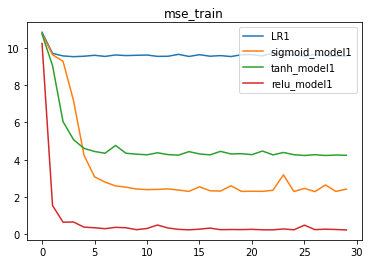

In [33]:
# 训练误差
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), mse_train[i], label=name)
plt.legend(loc = 1)
plt.title('mse_train')

Text(0.5, 1.0, 'mse_test')

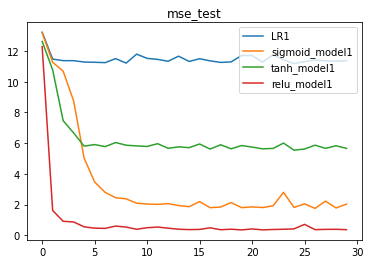

In [34]:
# 测试误差
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), mse_test[i], label=name)
plt.legend(loc = 1)
plt.title('mse_test')

从当前的实验能够看出，相比其他激活函数，ReLU激活函数效果明显更好。

- 激活函数性能简介与应用场景

&emsp;&emsp;根据当前的应用实践来看，ReLU激活函数是目前使用面最广、效果也相对更好的一种激活函数，但这并不代表tanh和Sigmoid激活函数就没有应用场景（比如RNN、LSTM模型仍然偏爱tanh和Sigmoid）。不同的激活函数拥有不同的特性，同时激活函数在复杂神经网络中的应用也是需要优化方法支持的，并且伴随着ReLU激活函数的不断应用，目前ReLU已经衍生出了一个激活函数簇，相关内容我们将在下一节详细讨论。

由于模型对比将是优化实验的常规操作，因此考虑将上述过程封装为一个函数：

In [35]:
def model_comparison(model_l, 
                     name_l, 
                     train_data,
                     test_data,
                     num_epochs = 20, 
                     criterion = nn.MSELoss(), 
                     optimizer = optim.SGD, 
                     lr = 0.03, 
                     cla = False, 
                     eva = mse_cal):
    """模型对比函数：
    
    :param model_l：模型序列
    :param name_l：模型名称序列
    :param train_data：训练数据
    :param test_data：测试数据    
    :param num_epochs：迭代轮数
    :param criterion: 损失函数
    :param lr: 学习率
    :param cla: 是否是分类模型
    :return：MSE张量矩阵 
    """
    # 模型评估指标矩阵
    train_l = torch.zeros(len(model_l), num_epochs)
    test_l = torch.zeros(len(model_l), num_epochs)
    # 模型训练过程
    for epochs in range(num_epochs):
        for i, model in enumerate(model_l):
            fit(net = model, 
                criterion = criterion, 
                optimizer = optimizer(model.parameters(), lr = lr), 
                batchdata = train_data, 
                epochs = epochs, 
                cla = cla)
            train_l[i][epochs] = eva(train_data, model).detach()
            test_l[i][epochs] = eva(test_data, model).detach()
    return train_l, test_l

## 四、构建复杂神经网络

&emsp;&emsp;在初步判断ReLU激活函数效果好于Sigmoid激活函数和tanh激活函数之后，我们尝试增加模型复杂度，也就是添加隐藏层来构建更加复杂的神经网络模型。

### 1.ReLU激活函数叠加

&emsp;&emsp;首先是ReLU激活函数的叠加，那么我们考虑添加几层隐藏层并考虑在隐藏层中使用ReLU函数，也就是所谓的添加ReLU层。此处我们在ReLU_class1的基础上创建ReLU_class2结构如下：

<img src="https://i.loli.net/2021/02/08/qBxbuJfQlURjG8N.jpg" alt="51" style="zoom:40%;" />

In [36]:
class ReLU_class2(nn.Module):                                   
    def __init__(self, in_features=2, n_hidden_1=4, n_hidden_2=4, out_features=1, bias=True):       
        super(ReLU_class2, self).__init__()
        self.linear1 = nn.Linear(in_features, n_hidden_1, bias=bias)
        self.linear2 = nn.Linear(n_hidden_1, n_hidden_2, bias=bias)
        self.linear3 = nn.Linear(n_hidden_2, out_features, bias=bias)
        
    def forward(self, x):                                   
        z1 = self.linear1(x)
        p1 = torch.relu(z1)
        z2 = self.linear2(p1)
        p2 = torch.relu(z2)
        out = self.linear3(p2)
        return out

接下来，借助model_comparison函数进行模型性能测试

In [37]:
# 创建随机数种子
torch.manual_seed(24)  

# 实例化模型
relu_model1 = ReLU_class1()
relu_model2 = ReLU_class2()

# 模型列表容器
model_l = [relu_model1, relu_model2]           
name_l = ['relu_model1', 'relu_model2']

# 核心参数
num_epochs = 20
lr = 0.03

In [38]:
train_l, test_l = model_comparison(model_l = model_l, 
                                   name_l = name_l, 
                                   train_data = train_loader, 
                                   test_data = test_loader,
                                   num_epochs = num_epochs, 
                                   criterion = nn.MSELoss(), 
                                   optimizer = optim.SGD, 
                                   lr = 0.03, 
                                   cla = False, 
                                   eva = mse_cal)

Text(0.5, 1.0, 'mse_train')

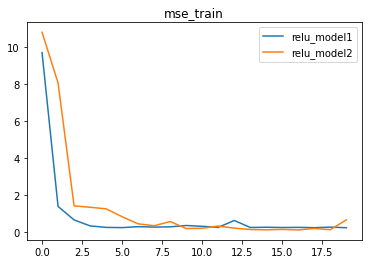

In [39]:
# 训练误差
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), train_l[i], label=name)
plt.legend(loc = 1)
plt.title('mse_train')

Text(0.5, 1.0, 'mse_train')

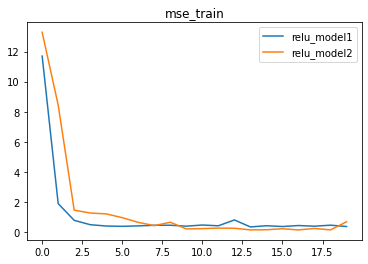

In [40]:
# 测试误差
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), test_l[i], label=name)
plt.legend(loc = 1)
plt.title('mse_train')

&emsp;&emsp;我们发现，模型效果并没有明显提升，反而出现了更多的波动，迭代收敛速度也有所下降。模型效果无法提升是不是因为模型还不够复杂，如果继续尝试添加隐藏层会有什么效果？

In [41]:
# 设置随机数种子
torch.manual_seed(420)  

# 创建最高项为2的多项式回归数据集
features, labels = tensorGenReg(w=[2, -1], bias=False, deg=2)

# 进行数据集切分与加载
train_loader, test_loader = split_loader(features, labels)

In [42]:
# 构建三个隐藏层的神经网络
class ReLU_class3(nn.Module):                                   
    def __init__(self, in_features=2, n_hidden1=4, n_hidden2=4, n_hidden3=4, out_features=1, bias=True):       
        super(ReLU_class3, self).__init__()
        self.linear1 = nn.Linear(in_features, n_hidden1, bias=bias)
        self.linear2 = nn.Linear(n_hidden1, n_hidden2, bias=bias)
        self.linear3 = nn.Linear(n_hidden2, n_hidden3, bias=bias)
        self.linear4 = nn.Linear(n_hidden3, out_features, bias=bias) 
        
    def forward(self, x):                                    
        z1 = self.linear1(x)
        p1 = torch.relu(z1)
        z2 = self.linear2(p1)
        p2 = torch.relu(z2)
        z3 = self.linear3(p2)
        p3 = torch.relu(z3)
        out = self.linear4(p3)
        return out


# 构建四个隐藏层的神经网络
class ReLU_class4(nn.Module):                                   
    def __init__(self, in_features=2, n_hidden1=4, n_hidden2=4, n_hidden3=4, n_hidden4=4, out_features=1, bias=True):       
        super(ReLU_class4, self).__init__()
        self.linear1 = nn.Linear(in_features, n_hidden1, bias=bias)
        self.linear2 = nn.Linear(n_hidden1, n_hidden2, bias=bias)
        self.linear3 = nn.Linear(n_hidden2, n_hidden3, bias=bias)
        self.linear4 = nn.Linear(n_hidden3, n_hidden4, bias=bias)
        self.linear5 = nn.Linear(n_hidden4, out_features, bias=bias) 
        
    def forward(self, x):                                    
        z1 = self.linear1(x)
        p1 = torch.relu(z1)
        z2 = self.linear2(p1)
        p2 = torch.relu(z2)
        z3 = self.linear3(p2)
        p3 = torch.relu(z3)
        z4 = self.linear4(p3)
        p4 = torch.relu(z4)
        out = self.linear5(p4)
        return out

In [43]:
# 创建随机数种子
torch.manual_seed(24)  

# 实例化模型
relu_model1 = ReLU_class1()
relu_model2 = ReLU_class2()
relu_model3 = ReLU_class3()
relu_model4 = ReLU_class4()

# 模型列表容器
model_l = [relu_model1, relu_model2, relu_model3, relu_model4]           
name_l = ['relu_model1', 'relu_model2', 'relu_model3', 'relu_model4']

# 核心参数
num_epochs = 20
lr = 0.03

In [44]:
train_l, test_l = model_comparison(model_l = model_l, 
                                   name_l = name_l, 
                                   train_data = train_loader, 
                                   test_data = test_loader,
                                   num_epochs = num_epochs, 
                                   criterion = nn.MSELoss(), 
                                   optimizer = optim.SGD, 
                                   lr = lr, 
                                   cla = False, 
                                   eva = mse_cal)

Text(0.5, 1.0, 'mse_train')

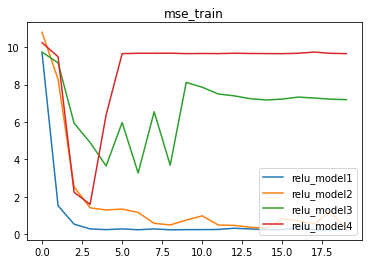

In [45]:
# 训练误差
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), train_l[i], label=name)
plt.legend(loc = 4)
plt.title('mse_train')

Text(0.5, 1.0, 'mse_test')

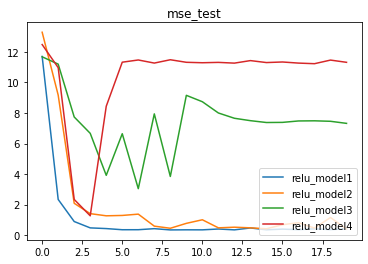

In [46]:
# 测试误差
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), test_l[i], label=name)
plt.legend(loc = 4)
plt.title('mse_test')

&emsp;&emsp;我们发现，在堆叠ReLU激活函数的过程中，模型效果并没有朝向预想的方向发展，MSE不仅没有越来越低，model3和model4甚至出现了模型失效的情况！这充分的说明，在当前技术手段下，模型构建并非越复杂越好。同时我们能够清晰的看到，伴随模型复杂度增加，模型收敛速度变慢、收敛过程波动增加、甚至有可能出现模型失效的情况。但同时我们又知道，深度学习本身就是一种构建复杂模型的方法，并且其核心价值就在于使用深度神经网络处理海量数据。从根本上来说，当前实验复杂模型出现问题并不是算法理论本身出了问题，而是我们缺乏了解决这些问题的“技术手段”，只有掌握了这些“技术手段”之后，才能真正构建运行高效、泛化能力强的模型。而这些技术手段，就是模型优化方法。其实这也从侧面说明了优化算法的重要性。      
&emsp;&emsp;关于优化方法的内容我们将在后续课程逐步介绍。在此之前，我们还需要看下Sigmoid激活函数tanh激活函数在堆叠过程中的表现，由此发现不同激活函数在深层次神经网络运行时存在的不同问题。

> 此处ReLU激活函数叠加后出现的模型失效问题，也就是Dead ReLU Problem。

### 2.Sigmoid激活函数叠加

&emsp;&emsp;同样，我们再构建拥有两个隐藏层、三个隐藏层和四个隐藏层的神经网络。

In [47]:
class Sigmoid_class2(nn.Module):                                   
    def __init__(self, in_features=2, n_hidden1=4, n_hidden2=4, out_features=1):       
        super(Sigmoid_class2, self).__init__()
        self.linear1 = nn.Linear(in_features, n_hidden1)
        self.linear2 = nn.Linear(n_hidden1, n_hidden2)
        self.linear3 = nn.Linear(n_hidden2, out_features) 
        
    def forward(self, x):                                    
        z1 = self.linear1(x)
        p1 = torch.sigmoid(z1)
        z2 = self.linear2(p1)
        p2 = torch.sigmoid(z2)
        out = self.linear3(p2)
        return out


class Sigmoid_class3(nn.Module):                                   
    def __init__(self, in_features=2, n_hidden1=4, n_hidden2=4, n_hidden3=4, out_features=1):       
        super(Sigmoid_class3, self).__init__()
        self.linear1 = nn.Linear(in_features, n_hidden1)
        self.linear2 = nn.Linear(n_hidden1, n_hidden2)
        self.linear3 = nn.Linear(n_hidden2, n_hidden3)
        self.linear4 = nn.Linear(n_hidden3, out_features) 
        
    def forward(self, x):                                    
        z1 = self.linear1(x)
        p1 = torch.sigmoid(z1)
        z2 = self.linear2(p1)
        p2 = torch.sigmoid(z2)
        z3 = self.linear3(p2)
        p3 = torch.sigmoid(z3)
        out = self.linear4(p3)
        return out

    
class Sigmoid_class4(nn.Module):                                   
    def __init__(self, in_features=2, n_hidden1=4, n_hidden2=4, n_hidden3=4, n_hidden4=4, out_features=1):       
        super(Sigmoid_class4, self).__init__()
        self.linear1 = nn.Linear(in_features, n_hidden1)
        self.linear2 = nn.Linear(n_hidden1, n_hidden2)
        self.linear3 = nn.Linear(n_hidden2, n_hidden3)
        self.linear4 = nn.Linear(n_hidden3, n_hidden4)
        self.linear5 = nn.Linear(n_hidden4, out_features) 
        
    def forward(self, x):                                    
        z1 = self.linear1(x)
        p1 = torch.sigmoid(z1)
        z2 = self.linear2(p1)
        p2 = torch.sigmoid(z2)
        z3 = self.linear3(p2)
        p3 = torch.sigmoid(z3)
        z4 = self.linear4(p3)
        p4 = torch.sigmoid(z4)
        out = self.linear5(p4)
        return out

然后在相同的数据集上测试模型效果

In [48]:
# 创建随机数种子
torch.manual_seed(24)  

# 实例化模型
sigmoid_model1 = Sigmoid_class1()
sigmoid_model2 = Sigmoid_class2()
sigmoid_model3 = Sigmoid_class3()
sigmoid_model4 = Sigmoid_class4()

# 模型列表容器
model_l = [sigmoid_model1, sigmoid_model2, sigmoid_model3, sigmoid_model4]           
name_l = ['sigmoid_model1', 'sigmoid_model2', 'sigmoid_model3', 'sigmoid_model4']

# 核心参数
num_epochs = 50
lr = 0.03

In [49]:
train_l, test_l = model_comparison(model_l = model_l, 
                                   name_l = name_l, 
                                   train_data = train_loader,
                                   test_data = test_loader,
                                   num_epochs = num_epochs, 
                                   criterion = nn.MSELoss(), 
                                   optimizer = optim.SGD, 
                                   lr = lr, 
                                   cla = False, 
                                   eva = mse_cal)

Text(0.5, 1.0, 'mse_train')

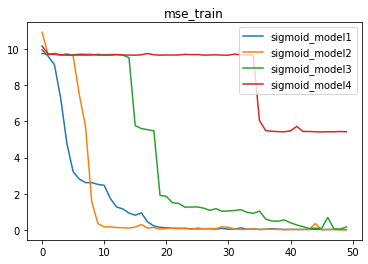

In [50]:
# 训练误差
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), train_l[i], label=name)
plt.legend(loc = 1)
plt.title('mse_train')

Text(0.5, 1.0, 'mse_test')

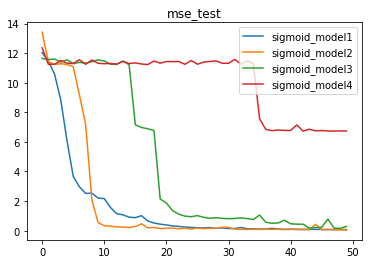

In [51]:
# 测试误差
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), test_l[i], label=name)
plt.legend(loc = 1)
plt.title('mse_test')

&emsp;&emsp;sigmoid激活函数的简单叠加也出现了很多问题，虽然没有像ReLU叠加一样出现大幅MSE升高的情况，但仔细观察，不难发现，对于model1、model2、model3来说，伴随模型复杂增加，模型效果没有提升，但收敛速度却下降的很严重，而model4更是没有收敛到其他几个模型的MSE，问题不小。不过相比ReLU激活函数，整体收敛过程确实稍显稳定，而Sigmoid也是老牌激活函数，在2000年以前，是最主流的激活函数。

> 此处Sigmoid激活函数堆叠后出现的问题，本质上就是梯度消失所导致的问题。

### 3.tanh激活函数叠加

&emsp;&emsp;最后，我们再来看下tanh激活函数叠加后的模型效果

In [52]:
class tanh_class2(nn.Module):                                   
    def __init__(self, in_features=2, n_hidden1=4, n_hidden2=4, out_features=1):       
        super(tanh_class2, self).__init__()
        self.linear1 = nn.Linear(in_features, n_hidden1)
        self.linear2 = nn.Linear(n_hidden1, n_hidden2)
        self.linear3 = nn.Linear(n_hidden2, out_features) 
        
    def forward(self, x):                                    
        z1 = self.linear1(x)
        p1 = torch.tanh(z1)
        z2 = self.linear2(p1)
        p2 = torch.tanh(z2)
        out = self.linear3(p2)
        return out

    
class tanh_class3(nn.Module):                                   
    def __init__(self, in_features=2, n_hidden1=4, n_hidden2=4, n_hidden3=4, out_features=1):       
        super(tanh_class3, self).__init__()
        self.linear1 = nn.Linear(in_features, n_hidden1)
        self.linear2 = nn.Linear(n_hidden1, n_hidden2)
        self.linear3 = nn.Linear(n_hidden2, n_hidden3)
        self.linear4 = nn.Linear(n_hidden3, out_features) 
        
    def forward(self, x):                                    
        z1 = self.linear1(x)
        p1 = torch.tanh(z1)
        z2 = self.linear2(p1)
        p2 = torch.tanh(z2)
        z3 = self.linear3(p2)
        p3 = torch.tanh(z3)
        out = self.linear4(p3)
        return out

    
class tanh_class4(nn.Module):                                   
    def __init__(self, in_features=2, n_hidden1=4, n_hidden2=4, n_hidden3=4, n_hidden4=4, out_features=1):       
        super(tanh_class4, self).__init__()
        self.linear1 = nn.Linear(in_features, n_hidden1)
        self.linear2 = nn.Linear(n_hidden1, n_hidden2)
        self.linear3 = nn.Linear(n_hidden2, n_hidden3)
        self.linear4 = nn.Linear(n_hidden3, n_hidden4)
        self.linear5 = nn.Linear(n_hidden4, out_features) 
        
    def forward(self, x):          
        z1 = self.linear1(x)
        p1 = torch.tanh(z1)
        z2 = self.linear2(p1)
        p2 = torch.tanh(z2)
        z3 = self.linear3(p2)
        p3 = torch.tanh(z3)
        z4 = self.linear4(p3)
        p4 = torch.tanh(z4)
        out = self.linear5(p4)
        return out

In [53]:
# 创建随机数种子
torch.manual_seed(42)  

# 实例化模型
tanh_model1 = tanh_class1()
tanh_model2 = tanh_class2()
tanh_model3 = tanh_class3()
tanh_model4 = tanh_class4()

# 模型列表容器
model_l = [tanh_model1, tanh_model2, tanh_model3, tanh_model4]           
name_l = ['tanh_model1', 'tanh_model2', 'tanh_model3', 'tanh_model4']

# 核心参数
num_epochs = 50
lr = 0.03  

In [54]:
train_l, test_l = model_comparison(model_l = model_l, 
                                   name_l = name_l, 
                                   train_data = train_loader,
                                   test_data = test_loader,
                                   num_epochs = num_epochs, 
                                   criterion = nn.MSELoss(), 
                                   optimizer = optim.SGD, 
                                   lr = lr, 
                                   cla = False, 
                                   eva = mse_cal)

Text(0.5, 1.0, 'mse_train')

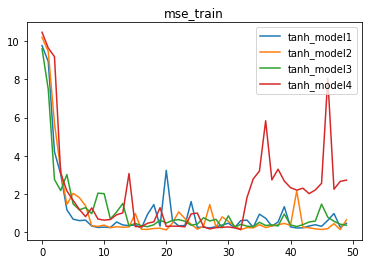

In [55]:
# 训练误差
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), train_l[i], label=name)
plt.legend(loc = 1)
plt.title('mse_train')

Text(0.5, 1.0, 'mse_test')

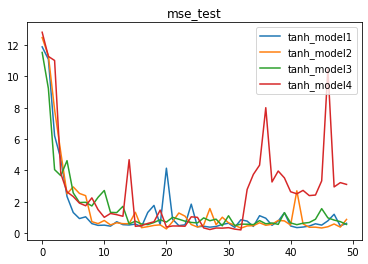

In [56]:
# 测试误差
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), test_l[i], label=name)
plt.legend(loc = 1)
plt.title('mse_test')

&emsp;&emsp;tanh激活函数叠加效果中规中矩，在model1到model2的过程效果明显向好，MSE基本一致、收敛速度基本一致、但收敛过程稳定性较好，也证明模型结果较为可信，而model3、model4则表现出了和前面两种激活函数在叠加过程中所出现的类似的问题，当然对于tanh来说，最明显的问题是出现了剧烈波动，甚至出现了“跳跃点”。

> 此处tanh激活函数堆叠所导致的迭代过程剧烈波动的问题，也被称为迭代不平稳，需要优化迭代过程来解决。

## 五、神经网络结构选择策略

### 1.参数和超参数

&emsp;&emsp;经过上述建模过程，我们可以对模型结构的选择略进行总结。

&emsp;&emsp;在实际建模过程中，神经网络的模型结构是影响建模结果至关重要的因素。但对于一个数据集，构建几层神经网络、每一层设置多少个神经元，却不是一个存在唯一最优解的参数，虽然我们希望能够有个数学过程帮我们直接确定模型结构，但由于影响因素较多，很多时候模型在确定模型结构上，还是一个首先根据经验设置模型结构、然后再根据实际建模效果不断调整的过程。

> 关于参数和超参数的说明：      
&emsp;&emsp;在机器学习中，参数其实分为两类，其一是参数，其二则是超参数，一个影响模型的变量是参数还是超参数，核心区别就在于这个变量的取值能否通过一个严谨的数学过程求出，如果可以，我们就称其为参数，如果不行，我们就称其为超参数。典型的，如简单线性回归中的自变量的权重，我们通过最小二乘法或者梯度下降算法，能够求得一组全域最优解，因此自变量的权重就是参数，类似的，复杂神经网络中的神经元连接权重也是参数。但除此以外，还有一类影响模型效果的变量却无法通过构建数学方程、然后采用优化算法算得最优解，典型的如训练集和测试集划分比例、神经网络的层数、每一层神经元个数等等，这些变量同样也会影响模型效果，但由于无法通过数学过程求得最优解，很多时候我们都是凭借经验设置数值，然后根据建模结果再进行手动调节，这类变量我们称其为超参数。      
&emsp;&emsp;不难发现，在实际机器学习建模过程中超参数出现的场景并不比参数出现的场景少，甚至很多时候，超参数的边界也和我们如何看待一个模型息息相关，例如，如果我们把“选什么模型”也看成是一个最终影响建模效果的变量，那这个变量也是一个超参数。也就是说，超参数也就是由“人来决策”的部分场合，而这部分也就是体现算法工程师核心竞争力的环节。           
&emsp;&emsp;当然，就像此前介绍的那样，参数通过优化算法计算出结果，而机器学习发展至今，也出现了很多辅助超参数调节的工具，比如网格搜索（grid search）、AutoML等，但哪怕是利用工具调整超参数，无数前辈在长期实践积累下来的建模经验仍然是弥足珍贵的，也是我们需要不断学习、不断理解，当然，更重要的是，所有技术人经验的积累是一个整体，因此也是需要我们参与分享的。

### 2.神经网络模型结构选择策略

而一般来说在模型结构选择方面，根据经验，有如下基本结论：

- 层数选择方面      
    - 三层以内：模型效果会随着层数增加而增加；
    - 三层至六层：随着层数的增加，模型的稳定性迭代的稳定性会受到影响，并且这种影响是随着层数增加“指数级”增加的，此时我们就需要采用一些优化方法对输入数据、激活函数、损失函数和迭代过程进行优化，一般来说在六层以内的神经网络在通用的优化算法配合下，是能够收敛至一个较好的结果的；
    - 六层以上：在模型超过六层之后，优化方法在一定程度上仍然能够辅助模型训练，但此时保障模型正常训练的更为核心的影响因素，就变成了数据量本身和算力。神经网络模型要迭代收敛至一个稳定的结果，所需的epoch是随着神经网络层数增加而增加的，也就是说神经网络模型越复杂，收敛所需迭代的轮数就越多，此时所需的算力也就越多。而另一方面，伴随着模型复杂度增加，训练所需的数据量也会增加，如果是复杂模型应用于小量样本数据，则极有可能会出现“过拟合”的问题从而影响模型的泛化能力。当然，伴随着模型复杂度提升、所需训练数据增加，对模型优化所采用的优化算法也会更加复杂。也就是说，六层以内神经网络应对六层以上的神经网络模型，我们需要更多的算力支持、更多的数据量、以及更加复杂的优化手段支持。

&emsp;&emsp;因此，对于大多数初中级算法工程师来说，如果不是借助已有经典模型而是自己构建模型的话，不建议搭建六层以上的神经网络模型。而关于通用优化方法，将在下一节开始逐步介绍。

- 每一层神经元个数选择方面：当然输入层的神经元个数就是特征个数，而输出层神经元个数，如果是回归类问题或者是逻辑回归解决二分类问题，输出层就只有一个神经元，而如果是多分类问题，输出层神经元个数就是类别总数。而隐藏层神经元个数，可以按照最多不超过输入特征的2-4倍进行设置，当然默认连接方式是全连接，每一个隐藏层可以设置相同数量的神经元。其实对于神经元个数设置来说，后期是有调整空间的，哪怕模型创建过程神经元数量有些“饱和”，我们后期我们可以通过丢弃法（优化方法的一种）对隐藏层神经元个数和连接方式进行修改。对于某些非结构化数据来说，隐藏层神经元个数也会根据数据情况来进行设置，如神经元数量和图像关键点数量匹配等。

另外，值得一提的是，经验是对过去的一般情况的总结，并不代表所有情况，同时也不代表对未来的预测。同时，上述规则适用于自定义神经网络模型的情况，很多针对某一类问题的经典深度学习架构会有单独的规则。

### 3.激活函数使用的单一性

&emsp;&emsp;同时，对于激活函数的交叉使用，我们需要知道，通常来说，是不会出现多种激活函数应用于一个神经网络中的情况的。主要原因并不是因为模型效果就一定会变差，而是如果几种激活函数效果类似，那么交叉使用几种激活函数其实效果和使用一种激活函数区别不大，而如果几种激活函数效果差异非常明显，那么这几种激活函数的堆加就会使得模型变得非常不可控。此前的实验让我们深刻体会优化算法的必要性，但目前工业界所掌握的、针对激活函数的优化算法都是针对某一种激活函数来使用的，激活函数的交叉使用会令这些优化算法失效。因此，尽管机器学习模型是“效果为王”，但在基础理论没有进一步突破之前，不推荐在一个神经网路中使用多种激活函数。